## Popularity Analysis

This analysis aims to identify and quantify any popularity bias in the recommendations. Businesses are categorized into popular and long-tail items based on a percentile cutoff following the Pareto Principle.


In [20]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_ranked_results = pd.read_csv('../Models_Deep_FM/all_ranked_results.csv')

In [79]:
# group by user_id and get the top 100 items for each user
df_ranked_results = df_ranked_results.groupby('user_id').head(100)
df_ranked_results_10 = df_ranked_results.groupby('user_id').head(10)

In [90]:
df_ranked_results['user_id'].unique()

array(['--4AjktZiHowEIBCMd4CZA', '--KsuCSkGGvDKTbdK9NvIg',
       '--Vu3Gux9nPnLcG9yO_HxA', '--XwFm4qERD6J5SX0JAsbg',
       '--_H9j6ggxvqhh9nPofZwg', '--_r6E98SNIrGU7weyNxbw',
       '--u09WAjW741FdfkJXxNmg', '-02tzlpQosZ9HE85jEtV6Q',
       '-05wJ5BVkv8lYBIC_H5F-Q', '-0H6Rm6dCi3pkFBC26HsoQ',
       '-0KrCHEsOcjJ6N4k_k1A9A', '-0rW5xrSCH1HCnSEmoQA5A',
       '-1-pTXLHph2vcqRCNeT4_Q', '-13RX4Gy_F-zoLIenWAo-w',
       '-16bjdAbpdPLuGrfGPSPNQ', '-1MF2tosrw2WcCxeVNk81Q',
       '-1MiSauypbVtNnWts4aXpA', '-1WbN1Qd-opw8u3uEqs2Kg',
       '-2cKJFFNJ9XVyWBt62mWvA', '-2nNiAnDaSbQayynsqgL6Q',
       '-2zeaby7CmyAb6AIjX0cmw', '-3HYmxW_5Gsg4I0eH3ju-Q',
       '-3agoL-p87vZteiDzrz5og', '-3m3CcApRSL_k2XSluzuMg',
       '-3s52C4zL_DHRK0ULG6qtg', '-43uAiZZ6wsGhaurBi3Cdw',
       '-4D4Q_Fxj_rEL32t0VtzFQ', '-4RMTrzXEjs0ttG7stsl2Q',
       '-4adygW78x5K_xSG0u3Y6Q', '-4mjLXqAoAtQjqDFo9q9WQ',
       '-4r6OoklyemH7Up70wIhMA', '-50lprJ4kZ-XCM1hPU2vqg',
       '-584avr5GMIqv-9Ut85Ywg', '-5Slg5hO3useiypXYgZkGg

In [57]:
# group by user_id and count the number of unique items
df_grouped = df_ranked_results.groupby('user_id')['business_id'].nunique().reset_index()
df_grouped.columns = ['user_id', 'unique_business_count']
df_grouped['unique_business_count'].value_counts()

unique_business_count
100    162
99      66
98      41
97      21
95      20
91      19
94      18
88      17
96      17
93      16
90      14
86      12
92      12
84      10
87      10
89      10
83       9
78       9
85       9
82       9
79       8
81       5
80       3
76       3
77       3
73       2
74       1
75       1
Name: count, dtype: int64

### import df_review

In [58]:
import sys
sys.path.append('../')
from utilities import *

In [59]:
# Define the database folder path and file names
db_folder = '../../data/processed_data/yelp_data/'
data_files = ['business', 'categories', 'review', 'user']

# Load data into a dictionary
yelp_data = load_data_from_db(db_folder, data_files)

# Check loaded data
for table, df in yelp_data.items():
    print(f"Loaded {len(df)} rows from {table} table.")

Loaded 78059 rows from business table.
Loaded 360656 rows from categories table.
Loaded 980418 rows from review table.
Loaded 229447 rows from user table.


In [60]:
df_business = yelp_data["business"]

In [61]:
business_data = df_business[['business_id', 'review_count']].dropna()
# Review counts for all businesses (for long-tail analysis)
review_counts = business_data['review_count'].sort_values(ascending=False)
total_reviews = review_counts.sum()

In [62]:

# Sort review counts descending
review_counts_sorted = business_data.sort_values("review_count", ascending=False).reset_index(drop=True)
review_counts_sorted['cum_reviews'] = review_counts_sorted['review_count'].cumsum()
review_counts_sorted['cum_percent'] = review_counts_sorted['cum_reviews'] / total_reviews

# Find the index where cumulative review % exceeds 80%
cutoff_index = review_counts_sorted[review_counts_sorted['cum_percent'] >= 0.8].index[0]
review_cutoff_value = review_counts_sorted.loc[cutoff_index, 'review_count']

# Define popular and long-tail items
popular_items = set(review_counts_sorted.loc[:cutoff_index, 'business_id'])
long_tail_items = set(review_counts_sorted.loc[cutoff_index+1:, 'business_id'])

print(f"Cutoff Review Count: {review_cutoff_value}")
print(f"# Popular Items: {len(popular_items)} | # Long-Tail Items: {len(long_tail_items)}")


Cutoff Review Count: 57
# Popular Items: 24959 | # Long-Tail Items: 53100


### ranking evaluation

In [63]:
df_ranked_results = df_ranked_results.sort_values(by=["user_id", "score"], ascending=[True, False])
grouped = df_ranked_results.groupby("user_id")
relevance_per_user = grouped["real_label"].apply(list).to_dict()

In [64]:
def mean_reciprocal_rank(relevance_dict):
    rr_list = []
    for rels in relevance_dict.values():
        try:
            rank = rels.index(1) + 1  # 1-based rank
            rr_list.append(1 / rank)
        except ValueError:
            rr_list.append(0)
    return np.mean(rr_list)


In [65]:
def first_relevant_rank(relevance_dict):
    ranks = []
    for rels in relevance_dict.values():
        try:
            rank = rels.index(1) + 1
        except ValueError:
            rank = None
        ranks.append(rank)
    return ranks  # return raw list for analysis


In [66]:
def dcg(rels, k=None):
    if k:
        rels = rels[:k]
    return sum((2**rel - 1) / np.log2(i + 2) for i, rel in enumerate(rels))

def ndcg_at_k(relevance_dict, k=10):
    scores = []
    for rels in relevance_dict.values():
        dcg_val = dcg(rels, k)
        ideal_rels = sorted(rels, reverse=True)
        idcg_val = dcg(ideal_rels, k)
        scores.append(dcg_val / idcg_val if idcg_val > 0 else 0)
    return np.mean(scores)

def ndcg_all(relevance_dict):
    return ndcg_at_k(relevance_dict, k=None)


In [67]:
def recall_at_k(relevance_dict, k=10):
    recalls = []
    for rels in relevance_dict.values():
        relevant_total = sum(rels)
        if relevant_total == 0:
            recalls.append(0)
            continue
        recalls.append(sum(rels[:k]) / relevant_total)
    return np.mean(recalls)


In [68]:
def average_precision(rels):
    score = 0
    hit_count = 0
    for i, rel in enumerate(rels):
        if rel == 1:
            hit_count += 1
            score += hit_count / (i + 1)
    return score / hit_count if hit_count > 0 else 0

def mean_average_precision(relevance_dict):
    return np.mean([average_precision(rels) for rels in relevance_dict.values()])


In [69]:
mrr = mean_reciprocal_rank(relevance_per_user)
first_ranks = first_relevant_rank(relevance_per_user)
ndcg_10 = ndcg_at_k(relevance_per_user, k=10)
ndcg_all_val = ndcg_all(relevance_per_user)
recall_10 = recall_at_k(relevance_per_user, k=10)
map_score = mean_average_precision(relevance_per_user)

print(f"MRR: {mrr:.4f}")
print(f"Mean First Relevant Rank: {np.mean([r for r in first_ranks if r is not None]):.2f}")
print(f"NDCG@10: {ndcg_10:.4f}")
print(f"NDCG_all: {ndcg_all_val:.4f}")
print(f"Recall@10: {recall_10:.4f}")
print(f"MAP: {map_score:.4f}")


MRR: 0.0004
Mean First Relevant Rank: 43.60
NDCG@10: 0.0000
NDCG_all: 0.0020
Recall@10: 0.0000
MAP: 0.0004


### popularity analysis

In [77]:
def compute_long_tail_metrics(recommendations_df, popular_items, long_tail_items):
    # Total number of unique businesses recommended
    unique_recommended_businesses = set(recommendations_df['business_id'])
    
    # Long-Tail Coverage: proportion of unique recommended businesses that are long-tail
    long_tail_recommended = unique_recommended_businesses.intersection(long_tail_items)
    long_tail_coverage = len(long_tail_recommended) / len(unique_recommended_businesses) if unique_recommended_businesses else 0

    # Popularity Bias: total # of recs that belong to popular items
    popular_recs = recommendations_df['business_id'].isin(popular_items).sum()
    total_recs = len(recommendations_df)
    popularity_bias = popular_recs / total_recs if total_recs else 0

    # Gini Coefficient (unchanged)
    rec_counts = recommendations_df['business_id'].value_counts()
    n = len(rec_counts)
    if n == 0:
        gini = 0
    else:
        sorted_counts = rec_counts.sort_values().values
        cum = np.cumsum(sorted_counts)
        gini = 1 - 2 * np.sum((cum - sorted_counts / 2) / cum[-1]) / n

    # change to float
    long_tail_coverage = float(long_tail_coverage)
    gini = float(gini)
    popularity_bias = float(popularity_bias)
    return long_tail_coverage, gini, popularity_bias

In [78]:
# Compute metrics
long_tail_coverage, gini, popularity_bias = compute_long_tail_metrics(df_ranked_results, popular_items, long_tail_items)
print(f"Long-Tail Coverage: {long_tail_coverage:.5f}")
print(f"Gini Coefficient: {gini:.5f}")
print(f"Popularity Bias: {popularity_bias:.5f}")


Long-Tail Coverage: 0.84382
Gini Coefficient: 0.78391
Popularity Bias: 0.79875


(np.float64(-1.0999999200589048),
 np.float64(1.0999999408353363),
 np.float64(-1.0999998304902014),
 np.float64(1.099999991928105))

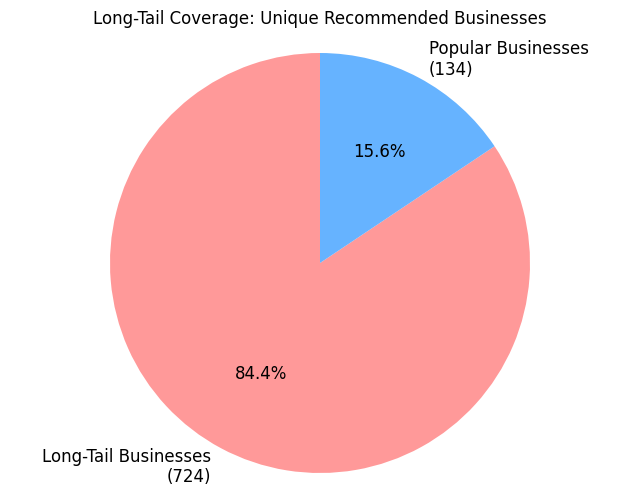

In [96]:
# Long-Tail Coverage Pie Chart
unique_recommended_businesses = set(df_ranked_results['business_id'])
long_tail_recommended = unique_recommended_businesses.intersection(long_tail_items)
popular_recommended = unique_recommended_businesses.intersection(popular_items)
long_tail_count = len(long_tail_recommended)
popular_count = len(popular_recommended)

plt.figure(figsize=(8, 6))
labels = [f'Long-Tail Businesses\n({long_tail_count})', f'Popular Businesses\n({popular_count})']
sizes = [long_tail_count, popular_count]
colors = ['#ff9999', '#66b3ff']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 12})
plt.title('Long-Tail Coverage: Unique Recommended Businesses')
plt.axis('equal')

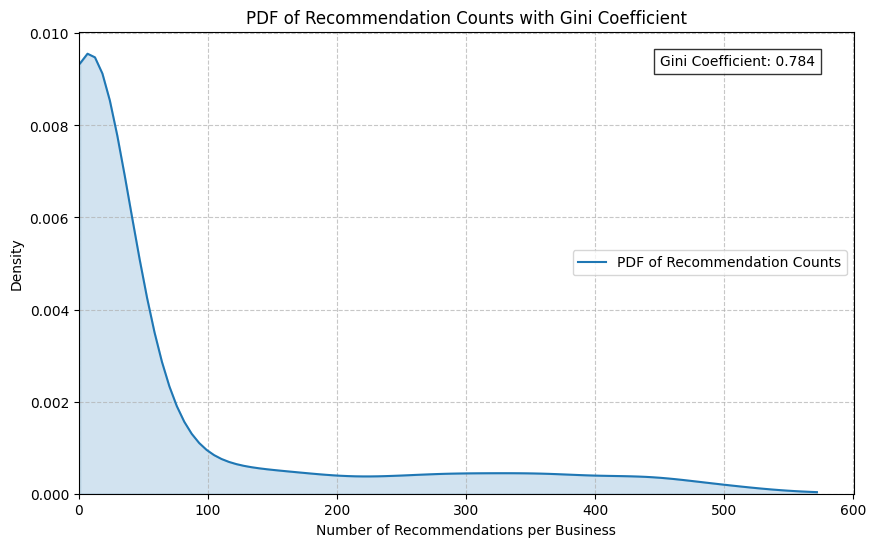

In [95]:
from scipy.stats import gaussian_kde

# Gini Coefficient PDF Plot
rec_counts = df_ranked_results['business_id'].value_counts().values
kde = gaussian_kde(rec_counts)
x = np.linspace(min(rec_counts), max(rec_counts), 100)
y = kde(x)

plt.figure(figsize=(10, 6))
plt.plot(x, y, color='#1f77b4', label='PDF of Recommendation Counts')
plt.fill_between(x, y, alpha=0.2, color='#1f77b4')
plt.title('PDF of Recommendation Counts with Gini Coefficient')
plt.xlabel('Number of Recommendations per Business')
plt.ylabel('Density')
plt.text(0.95, 0.95, f'Gini Coefficient: {gini:.3f}', transform=plt.gca().transAxes, 
         ha='right', va='top', bbox=dict(facecolor='white', alpha=0.8))
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.legend()